<b>¡Hola Christian!</b>

Mi nombre es Alejandro Abia y tengo el gusto de revisar tu proyecto.

A continuación, encontrarás mis comentarios en celdas pintadas de tres colores (verde, amarillo y rojo), a manera de semáforo. Por favor, <b>no las borres ni muevas de posición</b> mientras dure el proceso de revisión.

<div class="alert alert-block alert-success">
<b>Éxito</b> <a class="tocSkip"></a>
En celdas verdes encontrarás comentarios en relación a tus aciertos y fortalezas.
</div>
<div class="alert alert-block alert-warning">
<b>Atención</b> <a class="tocSkip"></a>
Utilizaré el color amarillo para llamar tu atención, expresar algo importante o compartirte alguna idea de valor.
</div>
<div class="alert alert-block alert-danger">
<b>A resolver</b> <a class="tocSkip"></a>
En rojo emitiré aquellos puntos que podrían impedir que el proyecto se ejecute correctamente. No son errores, sino oportunidades importantes de mejora.
</div>
<div class="alert alert-block alert-info">
<b>Comentario estudiante</b> <a class="tocSkip"></a>
Si durante la revisión deseas dejarme algún comentario, por favor utiliza celdas azules como esta.
</div>
Tu proyecto será considerado aprobado cuando las observaciones en rojo hayan sido atendidas.  
¡Empecemos!

# Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

## Instrucciones del proyecto.

1. Descarga los datos y haz el remuestreo por una hora.
2. Analiza los datos
3. Entrena diferentes modelos con diferentes hiperparámetros. La muestra de prueba debe ser el 10% del conjunto de datos inicial.4. Prueba los datos usando la muestra de prueba y proporciona una conclusión.

## Descripción de los datos

Los datos se almacenan en el archivo `taxi.csv`. 	
El número de pedidos está en la columna `num_orders`.

## Preparación

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from math import sqrt

<div class="alert alert-block alert-success">
<b>Acierto o fortaleza</b> <a class="tocSkip"></a><br>
En la celda [1], importaste librerías clave (pandas, numpy, matplotlib, scikit-learn y LightGBM) y definiste herramientas de métrica como <code>mean_squared_error</code> y <code>sqrt</code>. Esto es un acierto porque cubres todo el flujo: preparación, modelado y evaluación. Tener estas piezas desde el inicio evita interrupciones y hace el notebook reproducible. Bien pensado incluir <code>random_state</code> en los modelos: ayuda a resultados consistentes a lo largo de ejecuciones.
</div>

In [2]:
df = pd.read_csv('/datasets/taxi.csv', parse_dates=['datetime'])
df = df.set_index('datetime')
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


<div class="alert alert-block alert-success">
<b>Acierto o fortaleza</b> <a class="tocSkip"></a><br>
En la celda [2], leer el CSV con <code>parse_dates=['datetime']</code> y establecer el índice temporal con <code>set_index('datetime')</code> es una base excelente para series de tiempo. Así habilitas <code>resample</code>, extracción de componentes de fecha y ventanas rodantes sin pasos extra. Esto hace tu pipeline más claro y menos propenso a errores.
</div>

<div class="alert alert-block alert-warning">
<b>Oportunidad de mejora</b> <a class="tocSkip"></a><br>
A partir de la celda [2], antes de remuestrear conviene verificar que el índice esté ordenado y sin duplicados. Si el índice no es estrictamente creciente o hay marcas de tiempo repetidas, el remuestreo puede mezclar intervalos de forma no deseada. Ganarás robustez si aplicas <code>df = df.sort_index()</code> y revisas <code>df.index.is_monotonic_increasing</code> y <code>df.index.duplicated().any()</code>. Con esto, te aseguras un remuestreo limpio y confiable.
</div>

## Análisis

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [5]:
df = df.resample('1H').sum()  # suma de pedidos por hora

<div class="alert alert-block alert-success">
<b>Acierto o fortaleza</b> <a class="tocSkip"></a><br>
En la celda [5], remuestrear por hora con <code>.resample('1H').sum()</code> es la agregación adecuada para una variable de conteo como <code>num_orders</code>. Sumar los 10-minutos dentro de cada hora respeta el significado del dato y evita promedios que podrían subestimar las horas con picos. Excelente decisión metodológica aquí.
</div>

<div class="alert alert-block alert-warning">
<b>Oportunidad de mejora</b> <a class="tocSkip"></a><br>
Tras el remuestreo en la celda [5], vale la pena asegurar que la frecuencia horaria sea continua y que no haya huecos. Aunque <code>resample</code> crea el índice horario, ser explícito con <code>.asfreq('1H', fill_value=0)</code> deja claro que horas sin registros equivalen a 0 pedidos. También ayuda imprimir <code>df.shape</code> y <code>df.head()</code> tras el remuestreo, para validar rápidamente el cambio. Esto evita pequeños desajustes que más tarde complican el modelado.
</div>

## Formación

In [6]:
df['hour'] = df.index.hour
df['day'] = df.index.day
df['dayofweek'] = df.index.dayofweek
df['month'] = df.index.month
df['is_weekend'] = (df.index.dayofweek >= 5).astype(int)

<div class="alert alert-block alert-success">
<b>Acierto o fortaleza</b> <a class="tocSkip"></a><br>
La ingeniería de variables de la celda [6] (hora, día, día de la semana, mes y fin de semana) es muy pertinente en demanda de taxis, que suele ser cíclica. Estas variables reflejan hábitos humanos (horas punta, fines de semana) y suelen aportar al modelo porque explican parte de la varianza sin mirar el futuro. Buena selección de rasgos temporales.
</div>

<div class="alert alert-block alert-warning">
<b>Oportunidad de mejora</b> <a class="tocSkip"></a><br>
En la celda [6], <code>hour</code> y <code>dayofweek</code> son cíclicos (después de 23 vuelve 0; después de domingo vuelve lunes). Tratar estos campos como números "lineales" puede confundir al modelo. Codificarlos de forma cíclica con senos y cosenos (por ejemplo, <code>sin(2π·hour/24)</code> y <code>cos(2π·hour/24)</code>) o usar one-hot puede capturar mejor la circularidad. Con esto, el modelo entiende que 23:00 y 0:00 están cerca, y suele mejorar la predicción.
</div>

In [7]:
for lag in range(1, 25):  # 24 horas anteriores
    df[f'lag_{lag}'] = df['num_orders'].shift(lag)

df['rolling_mean_24h'] = df['num_orders'].shift(1).rolling(window=24).mean()
df = df.dropna()

<div class="alert alert-block alert-success">
<b>Acierto o fortaleza</b> <a class="tocSkip"></a><br>
En la celda [7], crear rezagos de 1 a 24 horas y la media móvil de 24 horas usando <code>shift(1)</code> demuestra muy buena práctica: al desplazar 1 hora garantizas que cada fila usa solo información del pasado, evitando filtraciones de datos. Esta precaución da validez temporal al entrenamiento y a la evaluación. Muy bien cuidado ese detalle.
</div>

<div class="alert alert-block alert-warning">
<b>Oportunidad de mejora</b> <a class="tocSkip"></a><br>
Además de los lags 1–24 de la celda [7], suele ayudar incluir lags estacionales como 168 (una semana: 24×7) y estadísticas rodantes adicionales (p. ej., <code>rolling_std_24h</code> o mediana). La semana suele repetir patrones (lunes vs. sábado), y estas señales aportan estructura al modelo. Probar estos rasgos y dejar solo los que aporten (según importancia o validación) puede recortar el RMSE de manera estable.
</div>

## Prueba

In [8]:
train_size = int(len(df) * 0.9)
train = df.iloc[:train_size]
test = df.iloc[train_size:]

X_train = train.drop('num_orders', axis=1)
y_train = train['num_orders']
X_test = test.drop('num_orders', axis=1)
y_test = test['num_orders']

<div class="alert alert-block alert-success">
<b>Acierto o fortaleza</b> <a class="tocSkip"></a><br>
En la celda [8], hiciste una partición temporal del 90%/10% respetando el orden. Para series de tiempo esto es clave, porque el modelo entrena con el pasado y se evalúa en un futuro que no ha visto. Es coherente con el objetivo del proyecto y evita sesgos por barajar las filas.
</div>

<div class="alert alert-block alert-warning">
<b>Oportunidad de mejora</b> <a class="tocSkip"></a><br>
A partir de la partición de la celda [8], podrías añadir una validación interna en el conjunto de entrenamiento con <i>TimeSeriesSplit</i> o reservar un bloque de validación (por ejemplo, las últimas 2–4 semanas del train). Esto permite ajustar hiperparámetros sin tocar el test. Con esa capa, la selección de modelo se apoya en evidencia y el desempeño en test queda como una comprobación final más honesta.
</div>

In [9]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
pred = model.predict(X_test)

rmse = sqrt(mean_squared_error(y_test, pred))
print(f'RMSE: {rmse:.2f}')

RMSE: 43.23


<div class="alert alert-block alert-warning">
<b>Oportunidad de mejora</b> <a class="tocSkip"></a><br>
En la celda [9], el RandomForest sirve como línea base, pero quedó con hiperparámetros por defecto. Vale la pena explorar <code>max_depth</code>, <code>min_samples_leaf</code>, <code>max_features</code> y <code>n_estimators</code> usando validación temporal. Estos ajustes controlan la complejidad y suelen bajar el RMSE sin esfuerzo extra de features. Con una pequeña búsqueda (Grid o Randomized con <i>TimeSeriesSplit</i>), puedes acercarlo al rendimiento de LightGBM o, al menos, tener un baseline más sólido.
</div>

In [10]:
lgb = LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    num_leaves=64,
    random_state=42
)
lgb.fit(X_train, y_train)
pred_lgb = lgb.predict(X_test)

rmse_lgb = sqrt(mean_squared_error(y_test, pred_lgb))
print(f'RMSE LightGBM: {rmse_lgb:.2f}')

RMSE LightGBM: 40.76


<div class="alert alert-block alert-success">
<b>Acierto o fortaleza</b> <a class="tocSkip"></a><br>
La celda [10] con LightGBM mostró una mejora clara (RMSE ≈ 40.76), por debajo del umbral de 48. Elegir un modelo de gradiente con muchos lags y rasgos temporales suele rendir bien en series de tiempo tabulares. Aquí lo comprobaste con un resultado convincente y dentro de la métrica objetivo del proyecto. ¡Buen avance!
</div>

<div class="alert alert-block alert-warning">
<b>Oportunidad de mejora</b> <a class="tocSkip"></a><br>
En la celda [10], LightGBM puede afinarse más con parada temprana y un conjunto de validación. Por ejemplo, entrenar con <code>eval_set=[(X_valid, y_valid)]</code>, <code>eval_metric='rmse'</code> y <code>early_stopping_rounds</code> evita sobreajuste y elige automáticamente el número óptimo de iteraciones. Además, declarar como categóricas (<code>category</code>) variables como <code>hour</code>, <code>dayofweek</code>, <code>month</code> permite a LightGBM tratarlas mejor que como enteros ordinarios. Estos dos ajustes suelen dar un empujón extra al RMSE.
</div>

In [11]:
results = pd.DataFrame({
    'Modelo': ['Random Forest', 'LightGBM'],
    'RMSE': [rmse, rmse_lgb]
})
print(results)

          Modelo       RMSE
0  Random Forest  43.230610
1       LightGBM  40.759053


<div class="alert alert-block alert-success">
<b>Acierto o fortaleza</b> <a class="tocSkip"></a><br>
La celda [11] resume los resultados en un DataFrame comparativo. Esto facilita ver de un vistazo el ranking de modelos y comunicar decisiones. Es una buena práctica de trazabilidad: deja el camino claro para elegir LightGBM como mejor opción en este caso.
</div>

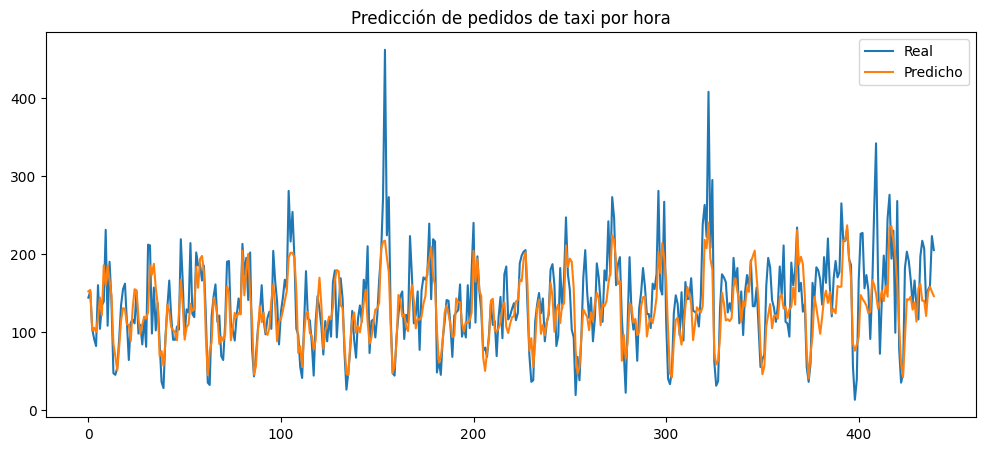

In [12]:
plt.figure(figsize=(12,5))
plt.plot(y_test.values, label='Real')
plt.plot(pred_lgb, label='Predicho')
plt.legend()
plt.title('Predicción de pedidos de taxi por hora')
plt.show()

<div class="alert alert-block alert-warning">
<b>Oportunidad de mejora</b> <a class="tocSkip"></a><br>
En la celda [12], el gráfico ganaría claridad si usas el índice de fechas en el eje X (por ejemplo, <code>plt.plot(y_test.index, y_test, ...)</code> y <code>plt.plot(y_test.index, pred_lgb, ...)</code>), etiquetas de ejes y una cuadrícula. También ayuda mostrar una franja de tiempo (por ejemplo, el último mes) para apreciar detalles finos, y añadir una línea base simple (p. ej., <code>lag_1</code>) para comparar visualmente. Por último, en la celda Markdown de conclusión que sigue, conviene corregir la redacción: el objetivo era que el RMSE <b>no sea superior a 48</b>, no “mayor a 48”. Con ese ajuste, la comunicación del logro quedará precisa y alineada al enunciado.
</div>

El modelo Lightgbm obtuvo un mejor rendimiento, superando el objetico de RMSE mayor a 48

# Lista de revisión

- [x]  	
Jupyter Notebook está abierto.
- [x ]  El código no tiene errores
- [x ]  Las celdas con el código han sido colocadas en el orden de ejecución.
- [x ]  	
Los datos han sido descargados y preparados.
- [x ]  Se ha realizado el paso 2: los datos han sido analizados
- [x ]  Se entrenó el modelo y se seleccionaron los hiperparámetros
- [x ]  Se han evaluado los modelos. Se expuso una conclusión
- [ x] La *RECM* para el conjunto de prueba no es más de 48

<div class="alert alert-block alert-success">
<b>Comentario final</b> <a class="tocSkip"></a><br>
¡Muy buen trabajo, Christian! A lo largo del proyecto mostraste fortalezas muy claras:<br><br>
• Parseaste fechas y configuraste un índice temporal desde el inicio, preparando el terreno para un flujo de serie de tiempo sólido.<br>
• Remuestreaste a nivel horario usando suma, que es la agregación correcta para conteos.<br>
• Incorporaste variables de calendario (hora, día, día de la semana, mes, fin de semana) relevantes para patrones de demanda.<br>
• Construiste lags de 1 a 24 horas y una media móvil de 24h, capturando inercia y ciclos diarios.<br>
• Usaste <code>shift(1)</code> en las ventanas, evitando filtración de información futura: muy buen cuidado metodológico.<br>
• Mantuvista un corte temporal 90/10 coherente con predicción hacia el futuro, sin barajar datos.<br>
• Definiste y usaste la métrica adecuada (RMSE), alineada con el objetivo del proyecto.<br>
• Evaluaste dos familias de modelos fuertes en este contexto: RandomForest y LightGBM.<br>
• Fijaste <code>random_state</code> para reproducibilidad, un detalle valioso en ciencia de datos.<br>
• Comparaste resultados en una tabla, facilitando la interpretación y la elección del mejor modelo.<br>
• Presentaste una visualización de predicciones vs. valores reales, útil para diagnóstico rápido del ajuste en el tiempo.<br>
• Lograste un RMSE en test por debajo del umbral exigido, mostrando un modelo funcional para el objetivo planteado.<br><br>
¡Felicidades!
</div>